# Exploring Strava Data

Here we will explore some Strava data from a regular runner (Jordan) with a view to being able to build predictive models of derived attributes from the data. 

Data is downloaded from Strava and stored as .fit.gz files. We'll read these in and look at some summary statistics to explore the shape of the data. Then we'll try to derive some interesting metrics from each run with a view to a predictive model.



In [10]:
import fitdecode
import gzip
import pandas

In [26]:
%matplotlib inline

In the sample file we find the following fields:
```
timestamp 2017-02-17 06:10:39+00:00
position_lat -406188716
position_long 1803403617
distance 0.0
enhanced_altitude -7.399999999999977
altitude -7.399999999999977
enhanced_speed 0.131
speed 0.131
cadence 0
fractional_cadence 0.0
```


In [136]:

def read_fitgz(fname, fields):
    """Read data from a .fit.gz file and return a data frame"""
        
    rows = []
    with gzip.open(fname, 'rb') as gz:
        with fitdecode.FitReader(gz) as fit:
            for frame in fit:
                row = {}
                if frame.frame_type == fitdecode.FIT_FRAME_DATA:

                    if frame.name == 'record': 
                        for field in frame.fields:
                            if field.name in fields:
                                row[field.name] = frame.get_value(field.name, fallback=0)
                if not row == {}:
                    rows.append(row)

    df = pandas.DataFrame(rows)
    df.index = pandas.to_datetime(df.timestamp)
    return df.drop(['timestamp'], axis=1)


def fitgz_fieldnames(fname):
    with gzip.open(fname, 'rb') as gz:
        with fitdecode.FitReader(gz) as fit:
            for frame in fit:
                if isinstance(frame, fitdecode.records.FitDataMessage):
                    if frame.name == 'record':
                        return [f.name for f in frame.fields]


def fitgz_summary(fname):
    """Generate summary statistics for a given fit.gz file"""

    thefields = fitgz_fieldnames(fname)
    df = read_fitgz(fname, thefields)

    fields = ['heart_rate', 'speed', 'cadence']
    result = {
        'timestamp': df.index[0],
        'distance': df.distance[-1],
        'duration': (df.index[-1] - df.index[0]).seconds
        }
    for f in fields:
        if f in df:
            # get mean, var of this field
            result[f+'_mean'] = df[f].mean()
            result[f+'_var'] = df[f].var()
    return result


In [121]:
fname = "data/jordan-activities/964335303.fit.gz"

thefields = fitgz_fieldnames(fname)
df = read_fitgz(fname, thefields)

In [123]:
df.head()

,position_lat,position_long,distance,enhanced_altitude,altitude,enhanced_speed,speed,heart_rate,cadence,fractional_cadence
timestamp,,,,,,,,,,
2017-01-24 08:57:52+00:00,-406150875,1803094105,0.83,4.2,4.2,1.754,1.754,35,53,0.0
2017-01-24 08:57:56+00:00,-406150167,1803094623,8.48,-2.6,-2.6,1.689,1.689,36,53,0.0
2017-01-24 08:57:59+00:00,-406148998,1803094952,19.58,-5.2,-5.2,1.875,1.875,40,86,0.0
2017-01-24 08:58:01+00:00,-406148285,1803094919,25.84,-8.6,-8.6,2.081,2.081,43,86,0.0
2017-01-24 08:58:05+00:00,-406146758,1803094992,40.00,-12.4,-12.4,2.333,2.333,47,86,0.0


<AxesSubplot:xlabel='timestamp'>

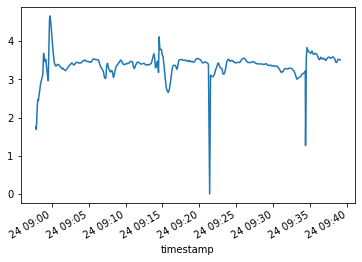

In [122]:
df['speed'].plot()

<AxesSubplot:xlabel='timestamp'>

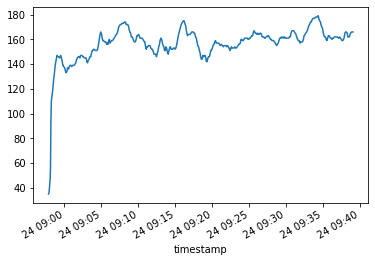

In [124]:
df['heart_rate'].plot()

In [103]:
fitgz_summary(fname)

{'timestamp': Timestamp('2017-01-24 08:57:52+0000', tz='UTC'),
 'distance': 8341.56,
 'duration': Timedelta('0 days 00:41:10'),
 'heart_rate_mean': 154.61165048543688,
 'heart_rate_var': 355.41572768289575,
 'speed_mean': 3.3543325242718454,
 'speed_var': 0.13018731738242,
 'cadence_mean': 83.86650485436893,
 'cadence_var': 10.437123520657712}

In [137]:
import os
dirname = 'data/jordan-activities'

def fitgz_directory(dirname):
    result = []
    for fname in os.listdir(dirname):
        if fname.endswith('.fit.gz'):
            result.append(fitgz_summary(os.path.join(dirname, fname)))

    return pandas.DataFrame(result)

allruns = fitgz_directory(dirname)
allruns.head()

,timestamp,distance,duration,speed_mean,speed_var,cadence_mean,cadence_var,heart_rate_mean,heart_rate_var
0,2017-03-17 22:23:47+00:00,134.69,301,0.806154,0.405839,31.538462,925.435897,NaN,NaN
1,2017-03-17 23:02:55+00:00,39.59,305,0.080200,0.002465,12.000000,720.000000,NaN,NaN
2,2017-03-19 02:50:32+00:00,89.43,152,0.986000,0.463317,47.833333,559.366667,NaN,NaN
3,2017-03-19 03:15:57+00:00,108.57,153,0.961000,0.274510,29.625000,1006.553571,NaN,NaN
4,2017-03-20 08:33:57+00:00,4476.17,1887,2.517789,0.132758,81.474104,173.026327,129.10757,87.664382


<AxesSubplot:xlabel='heart_rate_mean', ylabel='speed_mean'>

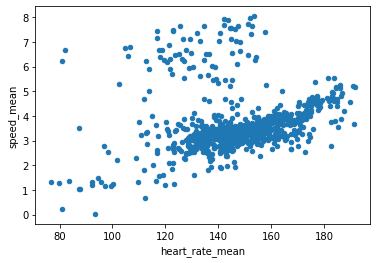

In [119]:
allruns.plot.scatter('heart_rate_mean', 'speed_mean')

In [125]:
allruns.shape

(1358, 9)

In [135]:
allruns.duration[0].seconds

301

In [134]:
df.head()

,position_lat,position_long,distance,enhanced_altitude,altitude,enhanced_speed,speed,heart_rate,cadence,fractional_cadence
timestamp,,,,,,,,,,
2017-01-24 08:57:52+00:00,-406150875,1803094105,0.83,4.2,4.2,1.754,1.754,35,53,0.0
2017-01-24 08:57:56+00:00,-406150167,1803094623,8.48,-2.6,-2.6,1.689,1.689,36,53,0.0
2017-01-24 08:57:59+00:00,-406148998,1803094952,19.58,-5.2,-5.2,1.875,1.875,40,86,0.0
2017-01-24 08:58:01+00:00,-406148285,1803094919,25.84,-8.6,-8.6,2.081,2.081,43,86,0.0
2017-01-24 08:58:05+00:00,-406146758,1803094992,40.00,-12.4,-12.4,2.333,2.333,47,86,0.0
